In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
identity  = lambda x: x
log       = lambda x: np.log(x)
loglog    = lambda x: np.log(np.log(x))
logloglog = lambda x: np.log(np.log(np.log(x)))
sqrt      = lambda x: np.sqrt(x)
cbrt      = lambda x: np.cbrt(x)

transform_dict = {
    "identity": identity,
    "log": log,
    "loglog": loglog,
    "logloglog": logloglog,
    "sqrt": sqrt,
    "cbrt": cbrt
}

In [3]:
def plot_feature_target(dataset, feature, transform):
    # Load data
    features_df = pd.read_csv('../training_data/' + dataset + '/features.csv')
    feature_df = features_df[feature]
    target_df = pd.read_csv('../training_data/' + dataset + '/target.csv')

    # Apply transformation
    x = transform_dict[transform](feature_df.to_numpy().reshape(-1, 1))
    y1 = target_df['min.log.lambda'].to_numpy()
    y2 = target_df['max.log.lambda'].to_numpy()

    # Randomly sample indices
    num_samples = 200
    if(num_samples > features_df.shape[1]):
        num_samples = features_df.shape[1]
    indices = np.random.choice(len(x), num_samples, replace=False)

    # Select samples
    x_sampled = x[indices]
    y1_sampled = y1[indices]
    y2_sampled = y2[indices]

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Plot (x, y1)
    ax1.plot(x_sampled, y1_sampled, 'o', markeredgecolor='black', markerfacecolor='none')
    ax1.set_xlabel("x = " + transform + '_' + feature)
    ax1.set_ylabel('y = lower target')
    ax1.set_title('Lower Bounds')
    ax1.grid(True)

    # Plot (x, y2)
    ax2.plot(x_sampled, y2_sampled, 'o', markeredgecolor='black', markerfacecolor='black')
    ax2.set_xlabel("x = " + transform + '_' + feature)
    ax2.set_ylabel('y = upper target')
    ax2.set_title('Upper Bounds')
    ax2.grid(True)

    plt.suptitle(dataset + " --- " + feature)
    plt.tight_layout()
    plt.show()

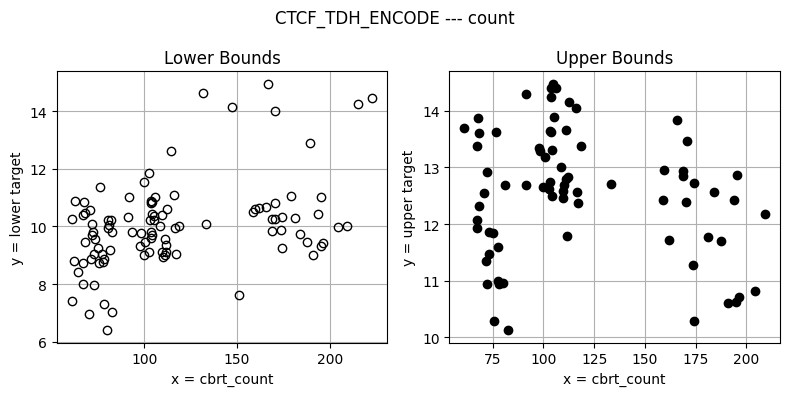

In [4]:
plot_feature_target('CTCF_TDH_ENCODE', 'count', 'cbrt')